# BA885 Team Project
#### Christian Lawrence, Tianzheng Mao, Tiam Moradi, Phoenix Wang

To access the dataset, please add the following shared folders to your working directory:
* https://tinyurl.com/3cn2zk8u (labeled images)
* https://tinyurl.com/ypaf8wtt (unlabeled images)

# Environment Setup

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import PIL
import PIL.Image
import pathlib
import matplotlib.image as mpimg
from matplotlib import rcParams
from pathlib import Path
import pathlib

# Data Setup

In [56]:
# load all the labeled images
data_dir = pathlib.Path('Labeled')
print('Total number of labeled images:', len(list(data_dir.glob('*/*.jpg'))))

Total number of labeled images: 17034


In [57]:
# put labeled images under their corresponding directory
labels = ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']
for i in labels:
    count = len(list(data_dir.glob(i+'/*')))
    locals()[i] = list(data_dir.glob(i+'/*'))
    print(f'There are {count} images in "{i}" directory.')

There are 2628 images in "building" directory.
There are 2745 images in "forest" directory.
There are 2957 images in "glacier" directory.
There are 3037 images in "mountain" directory.
There are 2784 images in "sea" directory.
There are 2883 images in "street" directory.


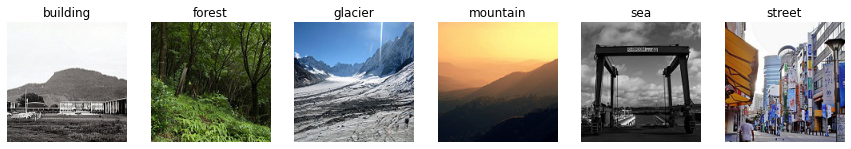

In [58]:
# display an image from each directory
rcParams['figure.figsize'] = 15, 5
fig, ax = plt.subplots(1, 6)

dirs = [building, forest, glacier, mountain, sea, street]
for i, v in enumerate(dirs):
    ax[i].imshow(PIL.Image.open(str(v[0])))
    ax[i].axis('off')
    ax[i].title.set_text(labels[i]);

In [59]:
# shape of each image
tf.keras.preprocessing.image.img_to_array(PIL.Image.open(str(building[0]))).shape

(150, 150, 3)

## Preprocessing

Use 80% of the images for training and 20% for validation.

In [60]:
batch_size = 32
img_height = 150
img_width = 150

In [61]:
# generate training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=885,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 17034 files belonging to 6 classes.
Using 13628 files for training.


In [62]:
# generate validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=885,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 17034 files belonging to 6 classes.
Using 3406 files for validation.


Each batch contains 32 images of shape `(150, 150, 3)` and their corresponding labels.

In [63]:
# shape of each batch
image_batch, label_batch = next(iter(train_ds))
print(image_batch.shape)
print(label_batch.shape)

(32, 150, 150, 3)
(32,)


## Standardization

The RGB channel values are in the `[0, 255]` range. We'll standardize the values to be in the `[0, 1]` range.

In [64]:
# value range from 0 to 255
image_batch, label_batch = next(iter(train_ds))
print('Minimum value:', np.min(image_batch))
print('Maximum value:', np.max(image_batch))

Minimum value: 0.0
Maximum value: 255.0


In [65]:
standardization = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)
train_ds = train_ds.map(lambda x, y: (standardization(x), y))
val_ds = val_ds.map(lambda x, y: (standardization(x), y))

In [66]:
# value range from 0 to 1
image_batch, label_batch = next(iter(train_ds))
print('Minimum value:', np.min(image_batch))
print('Maximum value:', np.max(image_batch))

Minimum value: 0.0
Maximum value: 1.0


# Model Building and Training

In [67]:
# configure performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [68]:
# # build model
# num_classes = 6
# model = tf.keras.Sequential([tf.keras.layers.Conv2D(32, 3, activation='relu'),
#                              tf.keras.layers.MaxPooling2D(),
#                              tf.keras.layers.Conv2D(32, 3, activation='relu'),
#                              tf.keras.layers.MaxPooling2D(),
#                              tf.keras.layers.Conv2D(32, 3, activation='relu'),
#                              tf.keras.layers.MaxPooling2D(),
#                              tf.keras.layers.Flatten(),
#                              # fully-connected layers
#                              tf.keras.layers.Dense(128, activation='relu'),
#                              tf.keras.layers.Dense(num_classes)
#                             ])

# model.compile(optimizer='adam',
#               loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [69]:
# # train model
# epochs = 10
# model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Model tuning

In [70]:
# tuner = kt.Hyperband(model,
#                      objective='val_accuracy',
#                      max_epochs=10,
#                      factor=3,
#                      directory='my_dir',
#                      project_name='intro_to_kt')
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [71]:
# tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [72]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,8]),
        activation='relu'
    ),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=8, max_value=16, step=2),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=8, max_value=16, step=2),
        activation='relu'
    ),
    keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [73]:

from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras

In [74]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="BA_885")

In [75]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,min_delta=0.0001)
tuner_search.search(train_ds, validation_data=val_ds,epochs=5,callbacks=[stop_early])

Trial 5 Complete [00h 00m 50s]
val_accuracy: 0.17909571528434753

Best val_accuracy So Far: 0.773341178894043
Total elapsed time: 00h 04m 11s
INFO:tensorflow:Oracle triggered exit


In [76]:
model=tuner_search.get_best_models(num_models=1)[0]

In [79]:
model.build(image_batch.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (32, 148, 148, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 74, 74, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 70, 70, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 35, 35, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 31, 31, 16)          25616     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 15, 15, 16)          0         
_________________________________________________________________
flatten (Flatten)            (32, 3600)                0

In [80]:
epochs = 10
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
426/426 [==============================] - 11s 25ms/step - loss: 0.5590 - accuracy: 0.7964 - val_loss: 0.6270 - val_accuracy: 0.7824
Epoch 2/10
426/426 [==============================] - 11s 26ms/step - loss: 0.5255 - accuracy: 0.8091 - val_loss: 0.5953 - val_accuracy: 0.7939
Epoch 3/10
426/426 [==============================] - 10s 24ms/step - loss: 0.4951 - accuracy: 0.8248 - val_loss: 0.5621 - val_accuracy: 0.8021
Epoch 4/10
426/426 [==============================] - 10s 24ms/step - loss: 0.4674 - accuracy: 0.8342 - val_loss: 0.5244 - val_accuracy: 0.8165
Epoch 5/10
426/426 [==============================] - 10s 23ms/step - loss: 0.4334 - accuracy: 0.8471 - val_loss: 0.5329 - val_accuracy: 0.8124
Epoch 6/10
426/426 [==============================] - 10s 24ms/step - loss: 0.4015 - accuracy: 0.8580 - val_loss: 0.5377 - val_accuracy: 0.8183
Epoch 7/10
426/426 [==============================] - 10s 24ms/step - loss: 0.3710 - accuracy: 0.8688 - val_loss: 0.6250 - val_accuracy: